In [3]:
# CMPT459 2020 spring
# milestone2
# SVM CLASSIFIER DEVELOPMENT
# group name: Salt
# develop memeber: Zheming Xu  ID: 301414922
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
def outlier_fd(data, threshold=0.5):
    low, high = np.percentile(data,1), np.percentile(data, 99)
    dist = high - low
    cut_off = dist * threshold
    lower, upper = low-cut_off, high+cut_off
    return [lower, upper]

def photos_number_counter(x):
    return len(x)

def valid_des(s):
    valid_s = " "
    for i in s.split():
        if i.isalnum():
            valid_s = " ".join([valid_s, i])
            
    return valid_s.strip()




In [4]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')

# Data Prepocessing for training data and test data

In [5]:
# combine train and test together for word constraints
ptrain = train
ptest = test
ptrain = ptrain.drop(['interest_level'], axis = 1)
pwhole = ptrain.append(ptest)

In [6]:
#Find the outlier of price, latitude and longitude using bound given by outlier_fd
[price_lower, price_higher] = outlier_fd(ptrain['price'])
[latitude_lower, latitude_higher] = outlier_fd(ptrain['latitude'],1)
[longitude_lower, longitude_higher] = outlier_fd(ptrain['longitude'],1)
#deal with outliers, set the column for modified data and plot again
pwhole['price_modify'] = pwhole['price']
pwhole['price_modify'].loc[pwhole['price_modify']<price_lower] = price_lower
pwhole['price_modify'].loc[pwhole['price_modify']>price_higher] = price_higher
#deal with outliers, set the column for modified data and plot again
pwhole['latitude_modify'] = pwhole['latitude']
pwhole['latitude_modify'].loc[pwhole['latitude_modify']<latitude_lower] = latitude_lower
pwhole['latitude_modify'].loc[pwhole['latitude_modify']>latitude_higher] = latitude_higher
#deal with outliers, set the column for modified data and plot again
pwhole['longitude_modify'] = pwhole['longitude']
pwhole['longitude_modify'].loc[pwhole['longitude']<longitude_lower] = longitude_lower
pwhole['longitude_modify'].loc[pwhole['longitude']>longitude_higher] = longitude_higher
#get the number of photos
pwhole['photos_number'] = pwhole['photos'].apply(photos_number_counter)
#set all feature words in count vector as features for train for feature_modify
pwhole['features_modify'] = pwhole['features'].apply(lambda x:" ".join(["_".join(i.split(" "))for i in x]))
counterf = CountVectorizer(max_features=100)
train_sparse_f = counterf.fit_transform(pwhole['features_modify'])
feature_list = counterf.get_feature_names()
array1 = train_sparse_f.toarray()
for i, feature_str in enumerate(feature_list):
    list_all = []
    [rows, cols] = array1.shape
    for row in range(rows):
        list_all.append(array1[row][i])
    feature_str_ = feature_str + '(f)'
    feature_v = pd.Series(list_all,pwhole.index, name = feature_str_)
    pwhole[feature_str_] = feature_v
#set all feature words in count vector as features for train for description_modify
pwhole['description_modify'] = pwhole['description'].apply(lambda x:valid_des(x))
counterd = CountVectorizer(stop_words=['features'], max_features=100)
train_sparse_d = counterd.fit_transform(pwhole['description_modify'])
description_list = counterd.get_feature_names()
array2 = train_sparse_d.toarray()
for i, description_str in enumerate(description_list):
    list_all = []
    [rows, cols] = array2.shape
    for row in range(rows):
        list_all.append(array2[row][i])
    description_str_ = description_str + '(d)'
    description_v = pd.Series(list_all,pwhole.index, name = description_str_)
    pwhole[description_str_] = description_v
## /*add something to change the created to year month day*/
pwhole['created']=pd.to_datetime(pwhole["created"])
pwhole['year']=pwhole['created'].dt.year
pwhole['month']=pwhole['created'].dt.month
pwhole['day']=pwhole['created'].dt.day


C:\AAA\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Feature selection

In [7]:
# mutual information
mic = mutual_info_classif(train.values, train['interest_level'].values.ravel())
mic
# drop some useless terms on 'feature' and 'description' manually
pwhole = pwhole.drop(['central_a(f)','in_super(f)','on(f)','pre(f)','war(f)'], axis = 1)
pwhole = pwhole.drop(['an(d)','and(d)','are(d)','as(d)','at(d)','be(d)','by(d)','can(d)','for(d)','from(d)','in(d)','is(d)','it(d)','just(d)','me(d)','more(d)','natural(d)','new(d)','or(d)','park(d)','that(d)','the(d)','this(d)','to(d)','will(d)','with(d)','you(d)','your(d)'], axis = 1)
# pwhole keep on dropping...
pwhole = pwhole.drop(["building_id", "created", "description", "display_address", "features", 
                     "manager_id", "photos", "street_address", "price", "longitude",
                        "latitude", "features_modify", "description_modify"], axis=1)

In [8]:
# get the polished version of train data and test data
# original: X_train.shape (49352, 176)    X_test.shape (74659, 176) X_train_label.shape (49352,3) high, low, medium
X_train = pwhole[:49352]
X_test = pwhole[49352:]
X_train = X_train.drop(['listing_id'], axis = 1)
X_test = X_test.drop(['listing_id'], axis = 1)
X_train_label = train['interest_level']
X_train_label.columns = [['interest_level']]

Now, we get three dataset: 

training sampleset(without label) -- X_train

test dataset -- X_test

training labelset -- X_train_label

Here,I list the columns of X_train to see all the features

In [10]:
list(X_train.columns)

['bathrooms',
 'bedrooms',
 'price_modify',
 'latitude_modify',
 'longitude_modify',
 'photos_number',
 '_photos(f)',
 'actual_apt(f)',
 'balcony(f)',
 'bike_room(f)',
 'cats_allowed(f)',
 'children(f)',
 'childrens_playroom(f)',
 'common_outdoor_space(f)',
 'common_parking(f)',
 'common_roof_deck(f)',
 'concierge(f)',
 'deck(f)',
 'dining_room(f)',
 'dishwasher(f)',
 'dogs_allowed(f)',
 'doorman(f)',
 'dryer(f)',
 'dryer_in_unit(f)',
 'duplex(f)',
 'eat_in_kitchen(f)',
 'elevator(f)',
 'exclusive(f)',
 'exposed_brick(f)',
 'fireplace(f)',
 'fitness(f)',
 'fitness_center(f)',
 'full(f)',
 'furnished(f)',
 'garage(f)',
 'garden(f)',
 'granite_kitchen(f)',
 'green_building(f)',
 'gym(f)',
 'hardwood(f)',
 'hardwood_floors(f)',
 'high_ceiling(f)',
 'high_ceilings(f)',
 'high_speed_internet(f)',
 'highrise(f)',
 'in_superintendent(f)',
 'laundry(f)',
 'laundry_in_building(f)',
 'laundry_in_unit(f)',
 'laundry_room(f)',
 'level(f)',
 'light(f)',
 'live(f)',
 'live_in_super(f)',
 'loft(f)',


In [32]:
# ignore this, just some attempts for choosing some features to combine as a new dataset 
# X_train1 (49352, 17) X_test1 (74659, 17)
X_train1 = X_train[['bathrooms','bedrooms','price_modify','latitude_modify','longitude_modify','photos_number','cats_allowed(f)','children(f)','dogs_allowed(f)','doorman(f)','fitness(f)','wifi_access(f)','access(d)','fitness(d)','year','month','day']]
X_test1 = X_test[['bathrooms','bedrooms','price_modify','latitude_modify','longitude_modify','photos_number','cats_allowed(f)','children(f)','dogs_allowed(f)','doorman(f)','fitness(f)','wifi_access(f)','access(d)','fitness(d)','year','month','day']]
# X_train2 (49352, 7) X_test2 (74659, 7)
X_train2 = X_train[['price_modify','latitude_modify','longitude_modify','photos_number','cats_allowed(f)','dogs_allowed(f)','wifi_access(f)']]
X_test2 = X_test[['price_modify','latitude_modify','longitude_modify','photos_number','cats_allowed(f)','dogs_allowed(f)','wifi_access(f)']]

# 5-fold Cross-validation

I choose 5-fold cross-validation here. I use KFold() to randomly divide the whole training dataset into 5 subsets, and randomly use one subset as the validation and the other for training. Here, tratrainset_set records the five training datasets, trainlabel_set records the corresponding labels for each of the five training set.And scores records the evaluation result of 5 validations using log_loss.(This process is really slow, which tooks me nearly the whole night to finish)

In [33]:
# reset index first
X_train = X_train.reset_index(drop=True)
X_train_label = X_train_label.reset_index(drop=True)
#5-fold cross validation
rkf = KFold(5,True,1)
trainset_set = []
trainlabel_set = []
scores = []
for train_index, test_index in rkf.split(X_train):
    print("train_index:{};\ntest_index:{}".format(train_index,test_index))
    #Xtrain: train part of tuples; Xtrainlabel: label of train part; Ytest: test part of tuples; Ytestlabel: label of test part
    Xtrain, Xtrainlabel = X_train.ix[train_index], X_train_label.ix[train_index]
    Ytest, Ytestlabel = X_train.ix[test_index], X_train_label.ix[test_index]
    print(Xtrain)
    print(Xtrainlabel)
    clf = svm.SVC(kernel = 'sigmoid', probability = True)
    clf.fit(Xtrain, Xtrainlabel)
    ypredict = clf.predict_proba(Ytest)
    truelabel = pd.get_dummies(Ytestlabel)
    #print(truelabel)
    score = log_loss(truelabel, ypredict)
    trainset_set.append(Xtrain)
    trainlabel_set.append(Xtrainlabel)
    scores.append(score)

train_index:[    0     1     3 ... 49349 49350 49351];
test_index:[    2    10    12 ... 49327 49333 49348]
       bathrooms  bedrooms  price_modify  latitude_modify  longitude_modify  \
0            1.0         1        2400.0          40.7108          -73.9539   
1            1.0         2        3800.0          40.7513          -73.9722   
3            1.5         3        3000.0          40.7145          -73.9425   
4            1.0         0        2795.0          40.7439          -73.9743   
5            1.0         3        7200.0          40.7348          -73.9865   
...          ...       ...           ...              ...               ...   
49346        1.0         0        2175.0          40.7640          -73.9917   
49347        1.0         3        2800.0          40.8433          -73.9396   
49349        1.0         1        1850.0          40.5765          -73.9554   
49350        1.0         2        4195.0          40.7448          -74.0017   
49351        1.0       

C:\AAA\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
C:\AAA\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\AAA\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


train_index:[    0     1     2 ... 49348 49350 49351];
test_index:[    3     8    11 ... 49336 49346 49349]


C:\AAA\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
C:\AAA\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


       bathrooms  bedrooms  price_modify  latitude_modify  longitude_modify  \
0            1.0         1        2400.0          40.7108          -73.9539   
1            1.0         2        3800.0          40.7513          -73.9722   
2            1.0         2        3495.0          40.7575          -73.9625   
4            1.0         0        2795.0          40.7439          -73.9743   
5            1.0         3        7200.0          40.7348          -73.9865   
...          ...       ...           ...              ...               ...   
49345        1.0         1        2750.0          40.7572          -73.9648   
49347        1.0         3        2800.0          40.8433          -73.9396   
49348        1.0         2        2395.0          40.8198          -73.9578   
49350        1.0         2        4195.0          40.7448          -74.0017   
49351        1.0         3        4280.0          40.7594          -73.9712   

       photos_number  _photos(f)  actual_apt(f)  ba

C:\AAA\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


train_index:[    1     2     3 ... 49349 49350 49351];
test_index:[    0    13    16 ... 49338 49342 49347]
       bathrooms  bedrooms  price_modify  latitude_modify  longitude_modify  \
1            1.0         2        3800.0          40.7513          -73.9722   
2            1.0         2        3495.0          40.7575          -73.9625   
3            1.5         3        3000.0          40.7145          -73.9425   
4            1.0         0        2795.0          40.7439          -73.9743   
5            1.0         3        7200.0          40.7348          -73.9865   
...          ...       ...           ...              ...               ...   
49346        1.0         0        2175.0          40.7640          -73.9917   
49348        1.0         2        2395.0          40.8198          -73.9578   
49349        1.0         1        1850.0          40.5765          -73.9554   
49350        1.0         2        4195.0          40.7448          -74.0017   
49351        1.0       

C:\AAA\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
C:\AAA\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\AAA\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


train_index:[    0     2     3 ... 49349 49350 49351];
test_index:[    1     4     5 ... 49341 49344 49345]
       bathrooms  bedrooms  price_modify  latitude_modify  longitude_modify  \
0            1.0         1        2400.0          40.7108          -73.9539   
2            1.0         2        3495.0          40.7575          -73.9625   
3            1.5         3        3000.0          40.7145          -73.9425   
8            0.0         1        2435.0          40.7346          -73.9811   
9            3.0         3        6850.0          40.6990          -73.9943   
...          ...       ...           ...              ...               ...   
49347        1.0         3        2800.0          40.8433          -73.9396   
49348        1.0         2        2395.0          40.8198          -73.9578   
49349        1.0         1        1850.0          40.5765          -73.9554   
49350        1.0         2        4195.0          40.7448          -74.0017   
49351        1.0       

C:\AAA\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
C:\AAA\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\AAA\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


train_index:[    0     1     2 ... 49347 49348 49349];
test_index:[    9    14    15 ... 49343 49350 49351]
       bathrooms  bedrooms  price_modify  latitude_modify  longitude_modify  \
0            1.0         1        2400.0          40.7108          -73.9539   
1            1.0         2        3800.0          40.7513          -73.9722   
2            1.0         2        3495.0          40.7575          -73.9625   
3            1.5         3        3000.0          40.7145          -73.9425   
4            1.0         0        2795.0          40.7439          -73.9743   
...          ...       ...           ...              ...               ...   
49345        1.0         1        2750.0          40.7572          -73.9648   
49346        1.0         0        2175.0          40.7640          -73.9917   
49347        1.0         3        2800.0          40.8433          -73.9396   
49348        1.0         2        2395.0          40.8198          -73.9578   
49349        1.0       

C:\AAA\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
C:\AAA\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\AAA\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Here is the score result. The five scores are close and all done well

In [34]:
scores

[0.7825596436078707,
 0.7896501500861506,
 0.7840817849490576,
 0.796680583450196,
 0.7901066673053336]

Here is the trainset_set. We can use one we think best to create the first version classifier

In [35]:
trainset_set

[       bathrooms  bedrooms  price_modify  latitude_modify  longitude_modify  \
 0            1.0         1        2400.0          40.7108          -73.9539   
 1            1.0         2        3800.0          40.7513          -73.9722   
 3            1.5         3        3000.0          40.7145          -73.9425   
 4            1.0         0        2795.0          40.7439          -73.9743   
 5            1.0         3        7200.0          40.7348          -73.9865   
 ...          ...       ...           ...              ...               ...   
 49346        1.0         0        2175.0          40.7640          -73.9917   
 49347        1.0         3        2800.0          40.8433          -73.9396   
 49349        1.0         1        1850.0          40.5765          -73.9554   
 49350        1.0         2        4195.0          40.7448          -74.0017   
 49351        1.0         3        4280.0          40.7594          -73.9712   
 
        photos_number  _photos(f)  act

Here is the trainlabel_set

In [38]:
trainlabel_set

[0        medium
 1           low
 3        medium
 4           low
 5           low
           ...  
 49346       low
 49347       low
 49349    medium
 49350    medium
 49351      high
 Name: interest_level, Length: 39481, dtype: object, 0        medium
 1           low
 2        medium
 4           low
 5           low
           ...  
 49345       low
 49347       low
 49348    medium
 49350    medium
 49351      high
 Name: interest_level, Length: 39481, dtype: object, 1           low
 2        medium
 3        medium
 4           low
 5           low
           ...  
 49346       low
 49348    medium
 49349    medium
 49350    medium
 49351      high
 Name: interest_level, Length: 39482, dtype: object, 0        medium
 2        medium
 3        medium
 8           low
 9           low
           ...  
 49347       low
 49348    medium
 49349    medium
 49350    medium
 49351      high
 Name: interest_level, Length: 39482, dtype: object, 0        medium
 1           low
 2        

# The first version classifier

In [43]:
# Here I use trainset_set[4] as the training data to perform the first version classifier
ftr = trainset_set[4]
flabel = trainlabel_set[4]
clf = svm.SVC(kernel = 'sigmoid', probability = True) # The parameters are these for first version
clf.fit(ftr, flabel)

In [44]:
Y_prediction = clf.predict_proba(X_test)
y = pd.DataFrame(Y_prediction)
y.reset_index(drop = True, inplace = True)
ids = test['listing_id']
ids.reset_index(drop = True, inplace = True)
out = pd.concat([ids, y], axis = 1, ignore_index = True)

In [45]:
Y_prediction

array([[0.07677624, 0.69547651, 0.22774725],
       [0.07677624, 0.69547651, 0.22774725],
       [0.07677624, 0.69547651, 0.22774725],
       ...,
       [0.07677624, 0.69547651, 0.22774725],
       [0.07677624, 0.69547651, 0.22774725],
       [0.07677624, 0.69547651, 0.22774725]])

In [46]:
#out.columns = ['listing_id', 'high', 'medium', 'low']
out.columns = ['listing_id', 'high', 'low', 'medium']
submission_file = open("submission2.csv","w")
out.to_csv('submission2.csv', index = False)
submission_file.close()

After the submission,
the score for validation is 0.79010


The score for test is 0.79213

# Improvement for SVM classifier

In [49]:
ftr2 = trainset_set[4]
flabel2 =  trainlabel_set[4]
ftest = X_test

Modify dataset and classify

In [58]:
# perform PCA on training and test dataset
pca=PCA(n_components=3)     
reduced_tr = pca.fit_transform(ftr2)
reduced_te = pca.fit_transform(ftest)
# classify
clf = svm.SVC(C = 1.0, kernel = 'sigmoid', gamma = 2, probability = True) # set gamma from auto to 2
clf.fit(reduced_tr, flabel2)
Y_prediction = clf.predict_proba(reduced_te)
y = pd.DataFrame(Y_prediction)
y.reset_index(drop = True, inplace = True)
ids = test['listing_id']
ids.reset_index(drop = True, inplace = True)
out = pd.concat([ids, y], axis = 1, ignore_index = True)
#out.columns = ['listing_id', 'high', 'medium', 'low']
out.columns = ['listing_id', 'high', 'low', 'medium']
submission_file = open("submission3.csv","w")
out.to_csv('submission3.csv', index = False)
submission_file.close()

After submission, the score is 0.79071

Modify the parameters of classifier

Test the C parameter in svm. It is also a overfitting detecting process

In [12]:
# overfitting observe
# here for overfitting we just need to consern about the parameter C in the SVM classifier
ftr2 = X_train[:39482]
flabel2 = X_train_label[:39482]
pca=PCA(n_components=3) 
reduced_tr = pca.fit_transform(ftr2)
reduced_te = pca.fit_transform(X_test)
##
C_options = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
##
Y_predict = []
for c in C_options:
    print(c)
    clf = svm.SVC(C = c, kernel = 'sigmoid', gamma = 2, probability = True)
    clf.fit(reduced_tr, flabel2)
    ypredict = clf.predict_proba(reduced_te)
    Y_predict.append(ypredict)

0.6
0.8
1.0
1.2
1.4
1.6
1.8
2.0
2.2
2.4
2.6


In [16]:
for i, y_predict in enumerate(Y_predict):
    print(i)
    y = pd.DataFrame(y_predict)
    y.reset_index(drop = True, inplace = True)
    ids = test['listing_id']
    ids.reset_index(drop = True, inplace = True)
    out = pd.concat([ids, y], axis = 1, ignore_index = True)
    #out.columns = ['listing_id', 'high', 'medium', 'low']
    out.columns = ['listing_id', 'high', 'low', 'medium']
    filename = "overfit_test"+str(i)+".csv"
    submission_file = open(filename,"w")
    out.to_csv(filename, index = False)
    submission_file.close()

0
1
2
3
4
5
6
7
8
9
10


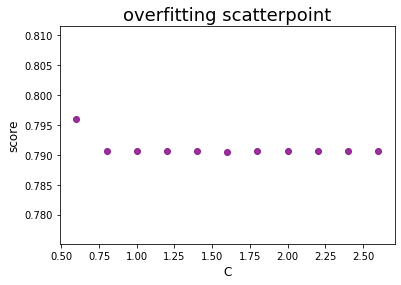

In [29]:
# after submit each file to the kaggle to get the score, I record all the scores in the ovscore
ovscore = [0.796060, 0.79071, 0.79065, 0.79065, 0.79066, 0.79056, 0.79063, 0.79071, 0.79065, 0.79063, 0.79060]
# we could plot ovscore vs C
C_options = pd.DataFrame(C_options)
ovscore = pd.DataFrame(ovscore)
plt.scatter(C_options, ovscore,alpha = 0.8, color = 'purple')
plt.title('overfitting scatterpoint', fontsize=18)
plt.xlabel('C', fontsize=12)
plt.ylabel('score', fontsize=12)
plt.show()

From this figure we could, for c from 0.6 to 2.6, when c got larger, the score remained nearly the same with a slight different. Maybe for larger c, there will be a clear observation of overfitting. So improvement, I choose the C option that gives the smallest score.

# Test for improved SVM classifier

In [30]:
clf = svm.SVC(C = 1.6, kernel = 'sigmoid', gamma = 2, probability = True) # set gamma from auto to 2
clf.fit(reduced_tr, flabel2)
Y_prediction = clf.predict_proba(reduced_te)
y = pd.DataFrame(Y_prediction)
y.reset_index(drop = True, inplace = True)
ids = test['listing_id']
ids.reset_index(drop = True, inplace = True)
out = pd.concat([ids, y], axis = 1, ignore_index = True)
#out.columns = ['listing_id', 'high', 'medium', 'low']
out.columns = ['listing_id', 'high', 'low', 'medium']
submission_file = open("submission4.csv","w")
out.to_csv('submission4.csv', index = False)
submission_file.close()

In [33]:
val = pca.fit_transform(X_train[39482:])
val_predict = clf.predict_proba(val)
truelabel = pd.get_dummies(X_train_label[39482:])
score = log_loss(truelabel, val_predict)
print(score)

0.7815129092597337


After the submission,the score is 0.78871, which got improved

The score for validation is 0.78151